This is the model implemented from [this paper](https://www.pnas.org/content/pnas/105/40/15346.full.pdf).

In [1]:
using AgentBasedModels
using GLMakie
using Random
using Distributions
using CUDA

# First part of the model: Physical interactions

In [ ]:
#UNITS: fg, μm, ms
fg = 1; μm = 1; ms = 1;
constants = Dict([
        :kn => .0001,#2*10^(-2)*ms^2/fg*10,
        :γn => 1,#2.20*10^2*sqrt(10)ms/10,
        :γt => 1,#2.20*10^2*sqrt(10)ms/10,
        :μcc => 0.1,
        :μcw => 0.8,
        :β => .5,
        :βω => .1
        ]);

constantsGrowth = Dict([
        :growth => 0.0001*ms/μm,
        :lMax => 3*μm,
        :σLTarget => 1*μm,
        :σTorqueDivision => .01
        ]);

In [ ]:
model = @agent(2,
            [vx,vy,theta,ω,d,l,m]::Local, #Local parameters
            [Fx,Fy,W]::LocalInteraction,    #Local Interaction Parameters
            [kn,γn,γt,μcc,μcw,β,βω]::Global,#Global parameters
    
            [pxAuxi,pxAuxj,pyAuxi,pyAuxj]::Local, #AUXILIAR FOR VISUALIZING POINTS

            UpdateInteraction = begin
                #Compute distance between centers of mass
                dAux = sqrt((x.i-x.j)^2+(y.i-y.j)^2)
                xiAux = x.i; xjAux = x.j; yiAux = y.i; yjAux = y.j; #Declare them in the global scope
                if dAux > 0 && dAux < (l.i+d.i+l.j+d.j)/2
                    #Compute intersecting point of the extended direction
                    cxAux = (x.i-x.j)
                    cyAux = (y.i-y.j)
                    normAux = cos(theta.i)*sin(theta.j)-sin(theta.i)*cos(theta.j)
                    if abs(normAux) > 0.0000001
                        scaleAux = (-sin(theta.j)*cxAux+cos(theta.j)*cyAux)/normAux
                        pxAux = scaleAux*cos(theta.i)+x.i
                        pyAux = scaleAux*sin(theta.i)+y.i
                    else
                        pxAux = x.i+10000*l.i*cos(theta.i)
                        pyAux = y.i+10000*l.i*sin(theta.i)
                    end
                        
                    #Compute distance from mass center of both rods
                    di = sqrt((x.i-pxAux)^2+(y.i-pyAux)^2)
                    dj = sqrt((x.j-pxAux)^2+(y.j-pyAux)^2)

                    if di<=l.i/2 && dj<=l.j/2 #Case that the intersecting point lies inside both rods
                        if di != 0
                            dxi = (pxAux-x.i)/di
                            dyi = (pyAux-y.i)/di
                            xiAux = .99*min(di,l.i/2)*dxi+x.i
                            yiAux = .99*min(di,l.i/2)*dyi+y.i
                        else
                            xiAux = x.i
                            yiAux = y.i
                        end

                        if dj != 0
                            dxj = (pxAux-x.j)/dj
                            dyj = (pyAux-y.j)/dj
                            xjAux = .99*min(dj,l.j/2)*dxj+x.j
                            yjAux = .99*min(dj,l.j/2)*dyj+y.j
                        else
                            xjAux = x.j
                            yjAux = y.j
                        end
                    elseif di>l.i/2 && dj<=l.j/2 #Case that the intersecting point inside second rod
                        #Compute position of the tip of the rod 1
                        dxi = (pxAux-x.i)/di
                        dyi = (pyAux-y.i)/di
                        xiAux = l.i/2*dxi+x.i
                        yiAux = l.i/2*dyi+y.i                            
                        #Compute closest point over the line axis of the other rod
                        cx = x.j-xiAux
                        cy = y.j-yiAux
                        xjAux = (sin(theta.j)*cx-cos(theta.j)*cy)*sin(theta.j)+xiAux
                        yjAux = -(sin(theta.j)*cx-cos(theta.j)*cy)*cos(theta.j)+yiAux
                        #Compute distance to center of the other rod
                        dj = sqrt((x.j-xjAux)^2+(y.j-yjAux)^2)
                    elseif dj>l.j/2 && di<=l.i/2#Case that the intersecting point inside first rod
                        #Compute position of the tip of the rod 1
                        dxj = (pxAux-x.j)/dj
                        dyj = (pyAux-y.j)/dj
                        xjAux = l.j/2*dxj+x.j
                        yjAux = l.j/2*dyj+y.j                            
                        #Compute closest point over the line axis of the other rod
                        cx = x.i-xjAux
                        cy = y.i-yjAux
                        xiAux = (sin(theta.i)*cx-cos(theta.i)*cy)*sin(theta.i)+xjAux
                        yiAux = -(sin(theta.i)*cx-cos(theta.i)*cy)*cos(theta.i)+yjAux
                        #Compute distance to center of the other rod
                        di = sqrt((x.i-xiAux)^2+(y.i-yiAux)^2)
                    else  #Case that the intersecting point lies outside both rods
                        xiAux = l.i/2*cos(theta.i)+x.i
                        yiAux = l.i/2*sin(theta.i)+y.i       
                        #Compute closest point over the line axis of the other rod
                        cx = x.j-xiAux
                        cy = y.j-yiAux
                        xjAux = (sin(theta.j)*cx-cos(theta.j)*cy)*sin(theta.j)+xiAux
                        yjAux = -(sin(theta.j)*cx-cos(theta.j)*cy)*cos(theta.j)+yiAux
                        dj = sqrt((xjAux-x.j)^2+(yjAux-y.j)^2)
                        if dj > l.j/2
                            dxj = (xjAux-x.j)/dj
                            dyj = (yjAux-y.j)/dj
                            xjAux = l.j/2*dxj+x.j
                            yjAux = l.j/2*dyj+y.j   
                        end
                        rij = sqrt((xiAux-xjAux)^2 +(yiAux-yjAux)^2)
                    
                        xiAux2 = -l.i/2*cos(theta.i)+x.i
                        yiAux2 = -l.i/2*sin(theta.i)+y.i       
                        #Compute closest point over the line axis of the other rod
                        cx = x.j-xiAux2
                        cy = y.j-yiAux2
                        xjAux2 = (sin(theta.j)*cx-cos(theta.j)*cy)*sin(theta.j)+xiAux2
                        yjAux2 = -(sin(theta.j)*cx-cos(theta.j)*cy)*cos(theta.j)+yiAux2
                        dj = sqrt((xjAux2-x.j)^2+(yjAux2-y.j)^2)
                        if dj > l.j/2
                            dxj = (xjAux2-x.j)/dj
                            dyj = (yjAux2-y.j)/dj
                            xjAux2 = l.j/2*dxj+x.j
                            yjAux2 = l.j/2*dyj+y.j   
                        end
                        rij2 = sqrt((xiAux2-xjAux2)^2 +(yiAux2-yjAux2)^2)
                        if rij2 < rij
                            xiAux = xiAux2
                            xjAux = xjAux2
                            yiAux = yiAux2
                            yjAux = yjAux2
                            rij = rij2
                        end

                        xjAux2 = l.j/2*cos(theta.j)+x.j
                        yjAux2 = l.j/2*sin(theta.j)+y.j       
                        #Compute closest point over the line axis of the other rod
                        cx = x.i-xjAux2
                        cy = y.i-yjAux2
                        xiAux2 = (sin(theta.i)*cx-cos(theta.i)*cy)*sin(theta.i)+xjAux2
                        yiAux2 = -(sin(theta.i)*cx-cos(theta.i)*cy)*cos(theta.i)+yjAux2
                        di = sqrt((xiAux2-x.i)^2+(yiAux2-y.i)^2)
                        if di > l.i/2
                            dxi = (xiAux2-x.i)/di
                            dyi = (yiAux2-y.i)/di
                            xiAux2 = l.i/2*dxi+x.i
                            yiAux2 = l.i/2*dyi+y.i   
                        end
                        rij2 = sqrt((xiAux2-xjAux2)^2 +(yiAux2-yjAux2)^2)
                        if rij2 < rij
                            xiAux = xiAux2
                            xjAux = xjAux2
                            yiAux = yiAux2
                            yjAux = yjAux2
                            rij = rij2
                        end           
                
                        xjAux2 = -l.j/2*cos(theta.j)+x.j
                        yjAux2 = -l.j/2*sin(theta.j)+y.j       
                        #Compute closest point over the line axis of the other rod
                        cx = x.i-xjAux2
                        cy = y.i-yjAux2
                        xiAux2 = (sin(theta.i)*cx-cos(theta.i)*cy)*sin(theta.i)+xjAux2
                        yiAux2 = -(sin(theta.i)*cx-cos(theta.i)*cy)*cos(theta.i)+yjAux2
                        di = sqrt((xiAux2-x.i)^2+(yiAux2-y.i)^2)
                        if di > l.i/2
                            dxi = (xiAux2-x.i)/di
                            dyi = (yiAux2-y.i)/di
                            xiAux2 = l.i/2*dxi+x.i
                            yiAux2 = l.i/2*dyi+y.i   
                        end
                        rij2 = sqrt((xiAux2-xjAux2)^2 +(yiAux2-yjAux2)^2)
                        if rij2 < rij
                            xiAux = xiAux2
                            xjAux = xjAux2
                            yiAux = yiAux2
                            yjAux = yjAux2
                            rij = rij2
                        end  

                        if rij < (d.i+d.j)/2
                            s = sign((x.j-x.i)*cos(theta.i)+(y.j-y.i)*sin(theta.i))
                            Fx.i -= kn*s*(d.i-rij)*cos(theta.i)/2
                            Fy.i -= kn*s*(d.i-rij)*sin(theta.i)/2
                            Fx.j += kn*s*(d.i-rij)*cos(theta.i)/2
                            Fy.j += kn*s*(d.i-rij)*sin(theta.i)/2
                        end
                    end
                
                    #Compute distance between virtual spheres
                    rij = sqrt((xiAux-xjAux)^2 +(yiAux-yjAux)^2)
                    if rij > 0 && rij < (d.i+d.j)/2 #If it is smaller than a diameter
                        #Compute auxiliar
                        δAux = d.i - rij
                        MeAux = m.i/2
                        #Compute interaction
                        nijx = (xiAux-xjAux)/rij
                        nijy = (yiAux-yjAux)/rij
                        vijx = (vx.i-vx.j)
                        vijy = (vy.i-vy.j)
                        #Compute inner product
                        vnAux = nijx*vijx+nijy*vijy
                        #Compute normal and tangential forces
                        FnAux = kn*δAux^1.5-γn*MeAux*δAux*vnAux
                        FtAux = -min(γt*MeAux*δAux^.5,μcc*FnAux)
                        #Compute the interaction forces
                        Fijx = FnAux*nijx + FtAux*(vijx-vnAux*nijx)
                        Fijy = FnAux*nijy + FtAux*(vijy-vnAux*nijy)
                        #Append the interaction forces
                        Fx.i += Fijx/2
                        Fy.i += Fijy/2
                        #Append radial forces
                        W.i += ((xiAux-x.i)*Fijy - (yiAux-y.i)*Fijx)/2
                        #Append the interaction forces
                        Fx.j -= Fijx/2
                        Fy.j -= Fijy/2
                        #Append radial forces
                        W.j -= ((xiAux-x.i)*Fijy - (yiAux-y.i)*Fijx)/2
                    end
                    pxAuxi.i = xiAux  #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                    pyAuxi.i = yiAux  #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                    pxAuxj.i = xjAux  #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                    pyAuxj.i = yjAux  #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES   
                end
            end,

            UpdateVariable = begin
                d(x) = vx*dt
                d(y) = vy*dt
                d(vx) = -β*vx*dt+Fx/m*dt
                d(vy) = -β*vy*dt+Fy/m*dt
                d(theta) = ω*dt
                d(ω) = W/(m*(d+l)^2/12+m*d^2)*dt-βω*ω*dt
            end,
    );

modelComp = compile(model,integrator="Euler",platform="cpu");
#modelComp.program

## Test 0: Collision points

In [4]:
com = Community(modelComp,N=14);

for i in keys(constants)
    setindex!(com,constants[i],i)
end

com.m .= 1. /fg
com.d .= 1. /μm
com.l .= 5 /μm;

com.x .= [-15,-19,-1,3,13,15,-15,-14,-0,-1,14,15,-15,-20.8]
com.y .= [0,1,0,4,0,1,-10,-9,-10,-9,-10,-10,-20,-20]
com.theta .= [0,π/2,0,π/2,0,π/2,0,0.1,0,-0.1,0,0,0,0]

com.simulationBox .= [-25 20;-25 5]
com.radiusInteraction = 6;

In [5]:
dt = .01
modelComp = compile(model,neighbors="grid",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");
@time comt = modelComp.evolve(com,dt=dt,tMax=.02,dtSave=.02,nMax=100);

  3.118661 seconds (10.07 M allocations: 649.414 MiB, 2.99% gc time, 99.42% compilation time)


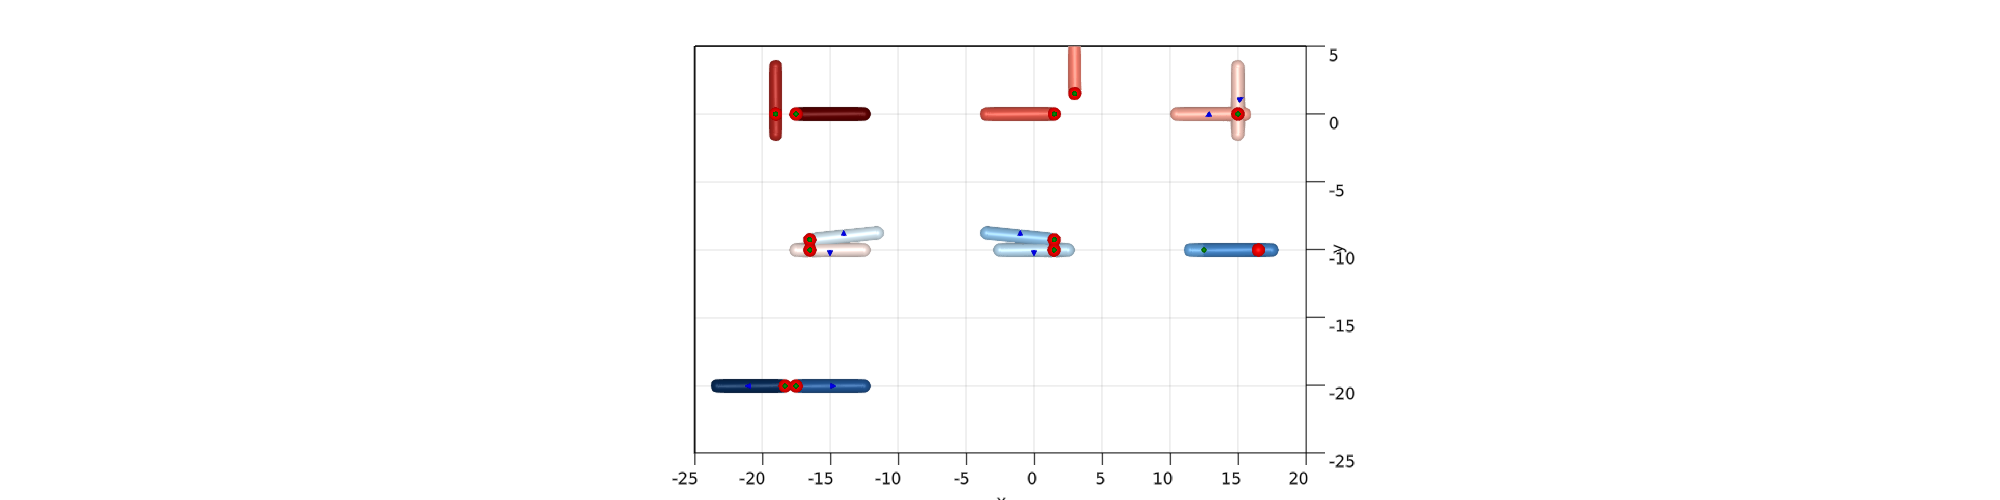

In [6]:
t_list = [2]

fig = Figure(resolution=(2000,500))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[t].N,2)
    rad = zeros(comt[t].N)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
        rad[i] = comt[t].d[i]/2
    end
    ax = plotRods(fig[i,1],comt[t],dir,:l,rad,color=[abs(i) for i in 1:com.N])

    xlims!(ax,com.simulationBox[1,1],com.simulationBox[1,2])
    ylims!(ax,com.simulationBox[2,1],com.simulationBox[2,2])
    
    for p in 1:2:com.N
        meshscatter!(ax,[comt[t].pxAuxi[p],comt[t].pxAuxj[p]],[comt[t].pyAuxi[p],comt[t].pyAuxj[p]],[2,2],markersize=.5,color=:red)
    end
    for p in 2:2:com.N
        meshscatter!(ax,[comt[t].pxAuxi[p],comt[t].pxAuxj[p]],[comt[t].pyAuxi[p],comt[t].pyAuxj[p]],[4,4],markersize=.2,color=:green)
    end
    
    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              comt[t].Fx*0.05, comt[t].Fy*0.05, zeros(comt[t].N),
              color=:blue,arrowsize=.5,linewidth=.2)
end

fig

## Test 1: Lateral repulsion short

### Stability of repulsion

In [7]:
modelComp = compile(model,integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");

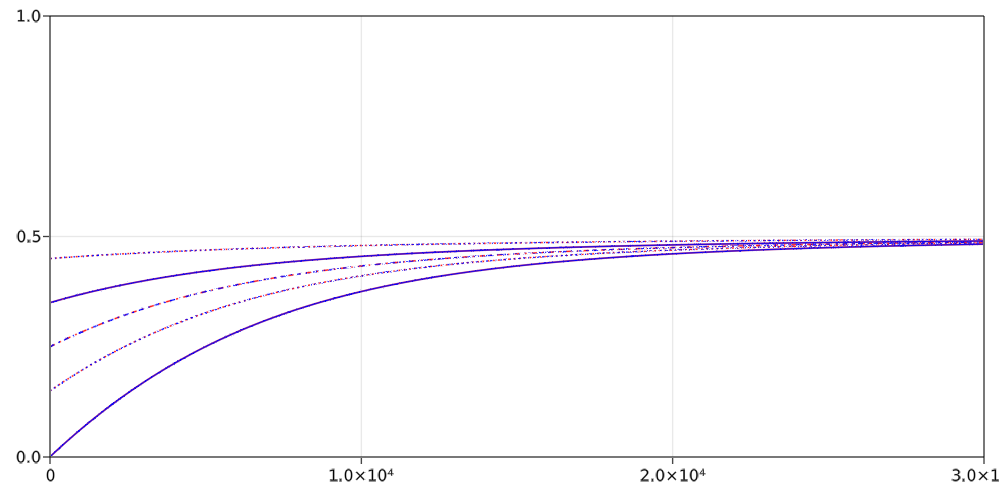

In [15]:
color = [:red,:blue,:green,:orange,:purple]
style = [:solid,:dot,:dashdot,:solid,:dot]
lineswidth = [1.3,1.2,1.1,1]

fig = Figure(resolution=(1000,500))
ax = Axis(fig[1,1])
for (i,dt) in enumerate([1,.1])
    for (j,sep) in enumerate([.001,.3,.5,.7,.9])
        com = Community(modelComp,N=2);
        
        for i in keys(constants)
            setindex!(com,constants[i],i)
        end

        com.m .= 1 /fg
        com.d .= 1. /μm
        com.l .= 5 /μm;

        com.x .= [0,0]
        com.y .= [-sep/2,sep/2]
        com.theta .= [0,0];
        
        comt = modelComp.evolve(com,dt=dt,tMax=30000)
        
        lines!(ax,comt.t,comt.y[:,2],color=color[i],linestyle=style[j],linewidth=lineswidth[i])
    end
end

ylims!(ax,0,1)
xlims!(ax,0,30000)

fig

### Several angles

In [19]:
com = Community(modelComp,N=8);

for i in keys(constants)
    setindex!(com,constants[i],i)
end

com.m .= 1 /fg
com.d .= 1. /μm
com.l .= 5 /μm;

com.x .= [-15,-15,-5,-5,5,5.1,15,15.1]
com.y .= [0.,.1,0,.1,0,0,0,0]
com.theta .= [0,0,0,π,π/2,π/2,π/2,-π/2];

com.simulationBox .= [-20 20; -5 5]
com.radiusInteraction = 6;

In [23]:
dt = 1
modelComp = compile(model,neighbors="full",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy]),platform="cpu");
@time comt = modelComp.evolve(com,dt=dt,tMax=30000,dtSave=1);

  1.620214 seconds (5.11 M allocations: 401.314 MiB, 4.70% gc time, 45.73% compilation time)


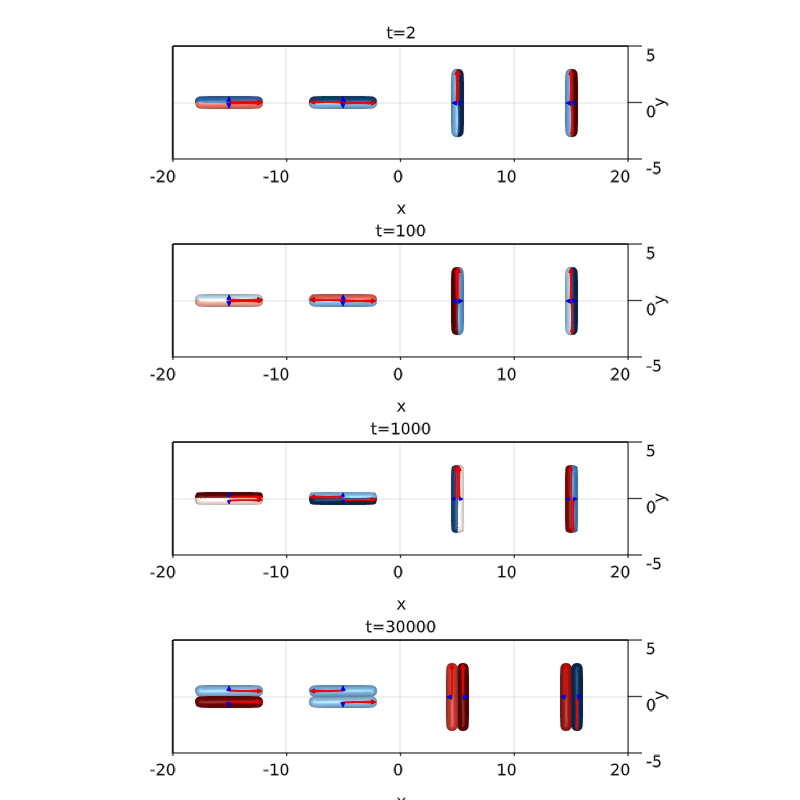

In [25]:
t_list = [2,100,1000,30000]

fig = Figure(resolution=(800,800))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[1].N,2)
    rad = zeros(comt[1].N)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
        rad[i] = comt[t].d[i]/2
    end
    ax = AgentBasedModels.plotRods(fig[i,1],comt[t],dir,:l,rad,color=rand(comt[t].N))
    
    ax.title = string("t=",t_list[i])
    xlims!(ax,com.simulationBox[1,1],com.simulationBox[1,2])
    ylims!(ax,com.simulationBox[2,1],com.simulationBox[2,2])

    #Plot interacting spheres
    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              cos.(comt[t].theta)*comt[t].l[1]/2, sin.(comt[t].theta)*comt[t].l[1]/2, zeros(comt[t].N),
              color=:red,arrowsize=.5,linewidth=.2)
    
    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              comt[t].Fx*0.05, comt[t].Fy*0.05, zeros(comt[t].N),
              color=:blue,arrowsize=.5,linewidth=.2)
end

fig

## Test 2: Lateral repulsion long

### Stability of repulsion aligned

In [31]:
modelComp = compile(model,integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");

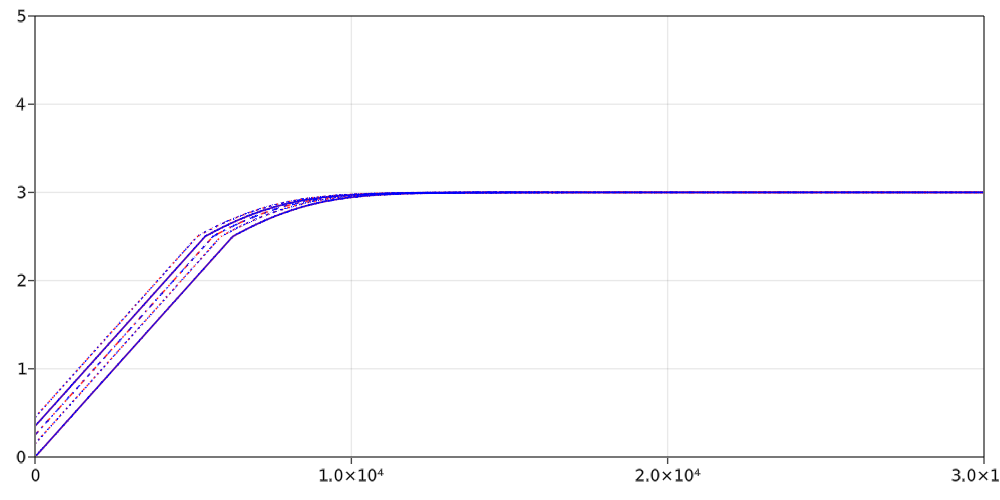

In [32]:
color = [:red,:blue,:green,:orange,:purple]
style = [:solid,:dot,:dashdot,:solid,:dot]
lineswidth = [1.3,1.2,1.1,1]

fig = Figure(resolution=(1000,500))
ax = Axis(fig[1,1])
for (i,dt) in enumerate([1,.1])
    for (j,sep) in enumerate([.001,.3,.5,.7,.9])
        com = Community(modelComp,N=2);
        
        for i in keys(constants)
            setindex!(com,constants[i],i)
        end

        com.m .= 1 /fg
        com.d .= 1. /μm
        com.l .= 5 /μm;

        com.x .= [-sep/2,sep/2]
        com.y .= [0,0]
        com.theta .= [0,0];
        
        comt = modelComp.evolve(com,dt=dt,tMax=30000)
        
        lines!(ax,comt.t,comt.x[:,2],color=color[i],linestyle=style[j],linewidth=lineswidth[i])
    end
end

ylims!(ax,0,5)
xlims!(ax,0,30000)

fig

### Stability of repulsion disaligned

In [34]:
modelComp = compile(model,integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");

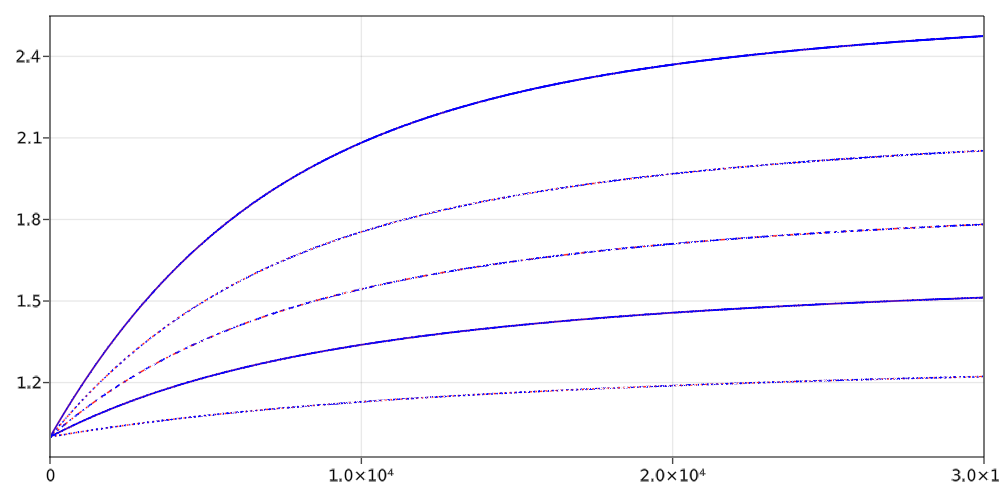

In [36]:
color = [:red,:blue,:green,:orange,:purple]
style = [:solid,:dot,:dashdot,:solid,:dot]
lineswidth = [1.3,1.2,1.1,1]

fig = Figure(resolution=(1000,500))
ax = Axis(fig[1,1])
for (i,dt) in enumerate([1,.1])
    for (j,sep) in enumerate([.001,.3,.5,.7,.9])
        com = Community(modelComp,N=2);
        
        for i in keys(constants)
            setindex!(com,constants[i],i)
        end

        com.m .= 1 /fg
        com.d .= 1. /μm
        com.l .= 5 /μm;

        com.x .= [0,1]
        com.y .= [-sep/2,sep/2]
        com.theta .= [0,0];
        
        comt = modelComp.evolve(com,dt=dt,tMax=30000)
        
        lines!(ax,comt.t,comt.x[:,2],color=color[i],linestyle=style[j],linewidth=lineswidth[i])
    end
end

#ylims!(ax,0,5)
xlims!(ax,0,30000)

fig

### Several angles

In [37]:
com = Community(modelComp,N=8);

for i in keys(constants)
    setindex!(com,constants[i],i)
end

com.m .= 1 /fg
com.d .= 1. /μm
com.l .= 5 /μm;

com.x .= [-15,-17.4,-15,-17.4,5,5,10,10]
com.y .= [5.,5.,-5,-5,0,2.4,0,2.4]
com.theta .= [0,0,0,π,π/2,π/2,π/2,-π/2];

com.simulationBox .= [-20 20; -10 10]
com.radiusInteraction = 6;

In [41]:
dt = 1
modelComp = compile(model,neighbors="full",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy]),platform="cpu");
@time comt = modelComp.evolve(com,dt=dt,tMax=30000,dtSave=1);

  1.714300 seconds (5.16 M allocations: 403.024 MiB, 40.09% compilation time)


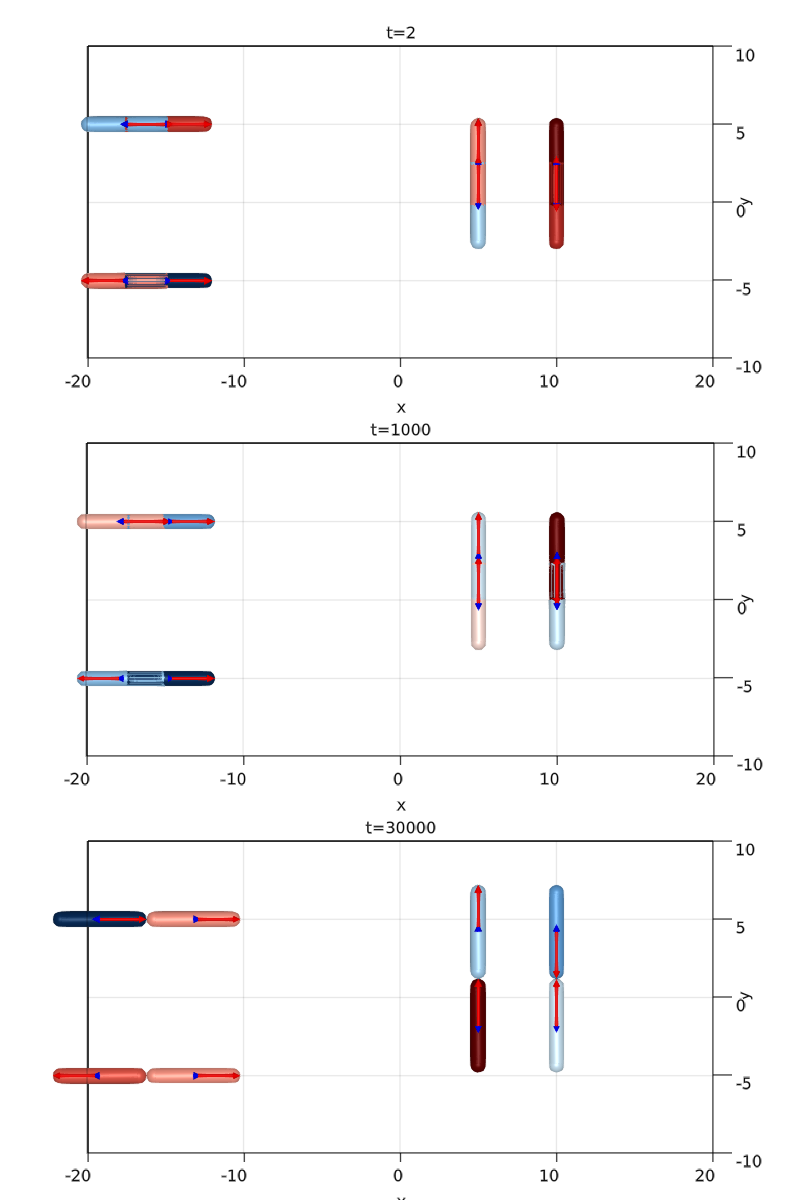

In [43]:
t_list = [2,10000,30000]

fig = Figure(resolution=(800,1200))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[1].N,2)
    rad = zeros(comt[1].N)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
        rad[i] = comt[t].d[i]/2
    end
    ax = AgentBasedModels.plotRods(fig[i,1],comt[t],dir,:l,rad,color=rand(comt[t].N))
    
    ax.title = string("t=",t_list[i])
    xlims!(ax,com.simulationBox[1,1],com.simulationBox[1,2])
    ylims!(ax,com.simulationBox[2,1],com.simulationBox[2,2])

    #Plot interacting spheres
    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              cos.(comt[t].theta)*comt[t].l[1]/2, sin.(comt[t].theta)*comt[t].l[1]/2, zeros(comt[t].N),
              color=:red,arrowsize=.5,linewidth=.2)
    
    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              comt[t].Fx, comt[t].Fy, zeros(comt[t].N),
              color=:blue,arrowsize=.5,linewidth=.2)
end

fig

## Test 3: Repulsion at different angles

### Stability of repulsion

In [44]:
modelComp = compile(model,integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");

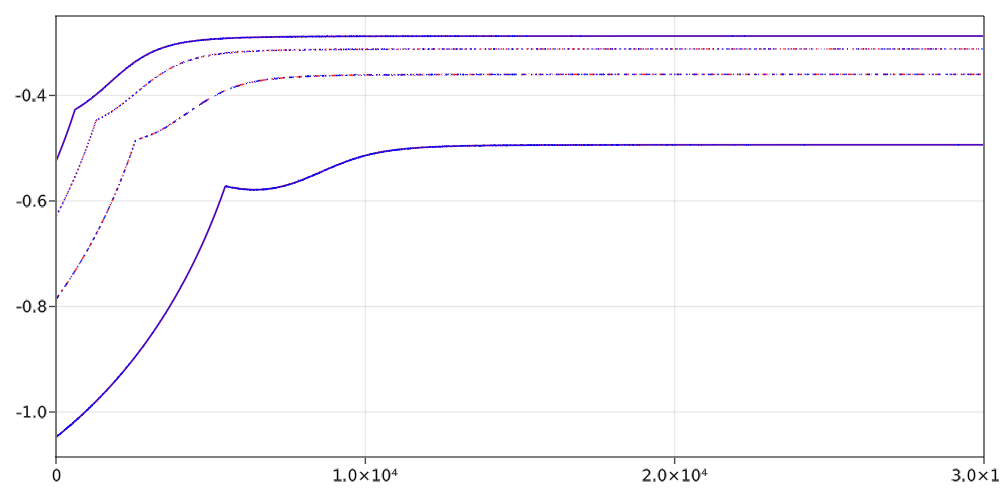

In [46]:
color = [:red,:blue,:green,:orange,:purple]
style = [:solid,:dot,:dashdot,:solid,:dot]
lineswidth = [1.3,1.2,1.1,1]

fig = Figure(resolution=(1000,500))
ax = Axis(fig[1,1])
for (i,dt) in enumerate([1,.1])
    for (j,sep) in enumerate([π/6,π/5,π/4,π/3])
        com = Community(modelComp,N=2);
        
        for i in keys(constants)
            setindex!(com,constants[i],i)
        end

        com.m .= 1 /fg
        com.d .= 1. /μm
        com.l .= 5 /μm;

        com.x .= [0,0]
        com.y .= [-1,1]
        com.theta .= [sep,-sep];
        
        comt = modelComp.evolve(com,dt=dt,tMax=30000)
        
        lines!(ax,comt.t,comt.theta[:,2],color=color[i],linestyle=style[j],linewidth=lineswidth[i])
    end
end

#ylims!(ax,0,5)
xlims!(ax,0,30000)

fig

### Several angles

In [47]:
com = Community(modelComp,N=8);

for i in keys(constants)
    setindex!(com,constants[i],i)
end

com.m .= 1.
com.d .= 1
com.l .= 5.;

com.x .= [-15,-14,-15,-15,15,14,15,14]
com.y .= [10.,11.,-10,-11,10,11,-10,-11]
com.theta .= [π/3,π/6,-2π/3,π/6,π/2,0,-π/2,π];

com.simulationBox .= [-20 20; -20 20]
com.radiusInteraction = 6;

In [48]:
dt = 1
modelComp = compile(model,neighbors="full",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy]),platform="cpu");
@time comt = modelComp.evolve(com,dt=dt,tMax=30000,dtSave=1);

  1.682528 seconds (4.90 M allocations: 393.122 MiB, 7.02% gc time, 43.52% compilation time)


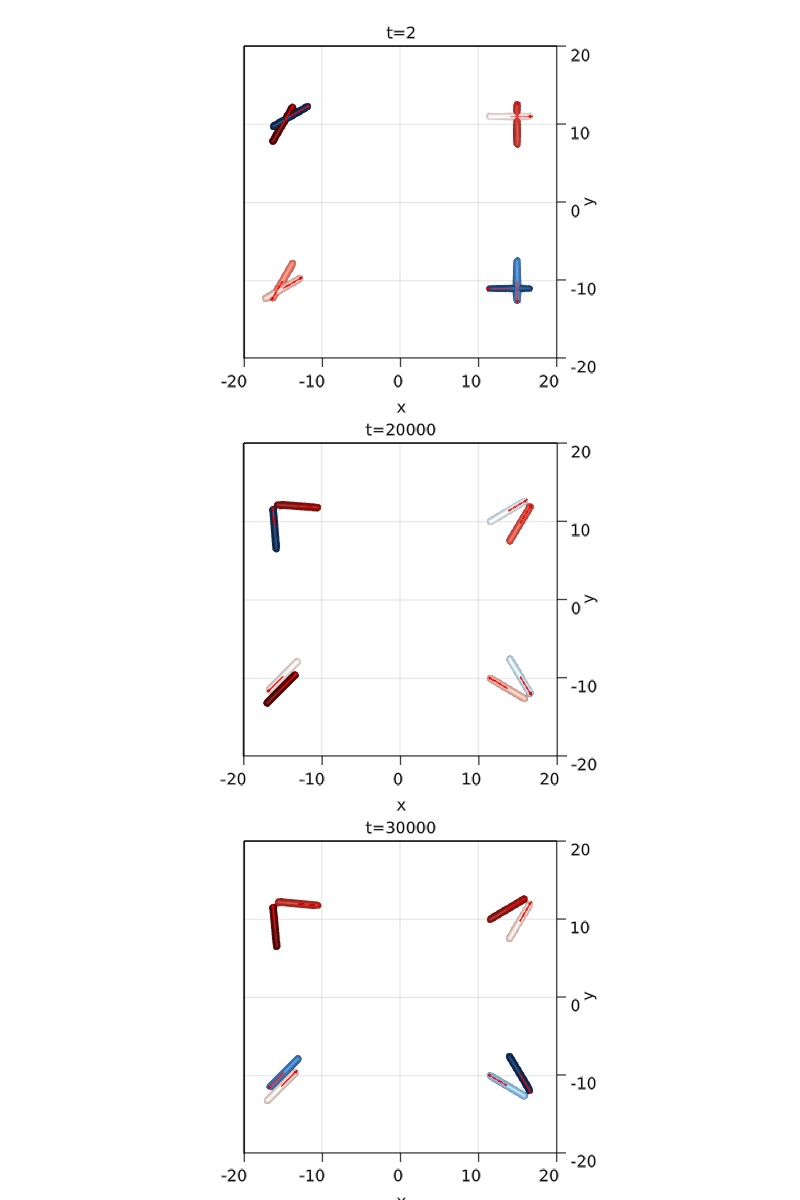

In [49]:
t_list = [2,20000,30000]

fig = Figure(resolution=(800,1200))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[1].N,2)
    rad = zeros(comt[1].N)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
        rad[i] = comt[t].d[i]/2
    end
    ax = AgentBasedModels.plotRods(fig[i,1],comt[t],dir,:l,rad,color=rand(comt[t].N))
    
    ax.title = string("t=",t_list[i])
    xlims!(ax,com.simulationBox[1,1],com.simulationBox[1,2])
    ylims!(ax,com.simulationBox[2,1],com.simulationBox[2,2])

    #Plot interacting spheres
    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              cos.(comt[t].theta)*comt[t].l[1]/2, sin.(comt[t].theta)*comt[t].l[1]/2, zeros(comt[t].N),
              color=:red,arrowsize=.5,linewidth=.2)
end

fig

## Test 4: Collision

In [50]:
modelCheck = @agent(2,
    model::BaseModel,
                    
    [pxi,pyi,pxj,pyj]::Local,
    
    UpdateInteraction=begin
        if id.i == 1 && dAux > 0 && dAux < (l.i + l.j) / 2
            pxi.i = xiAux 
            pyi.i = yiAux 
            pxi.j = xjAux 
            pyi.j = yjAux 
        end
        if id.j == 1 && dAux > 0 && dAux < (l.i + l.j) / 2
            pxj.i = xiAux
            pyj.i = yiAux 
            pxj.j = xjAux 
            pyj.j = yjAux 
        end
    end
)

modelComp = compile(modelCheck);

In [59]:
com = Community(modelComp,N=2);

for i in keys(constants)
    setindex!(com,constants[i],i)
end

com.m .= 1.
com.d .= 1
com.l .= 5.;

com.x = [0,2.4]
com.y = [0.,4]
com.vy = [0, -.8]
com.ω .= 0
com.theta = [0,π/2];

com.simulationBox .= [-10 10; -10 10]
com.radiusInteraction = 6;

In [69]:
dt = 1
modelComp = compile(modelCheck,neighbors="full",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy]),platform="cpu");
@time comt = modelComp.evolve(com,dt=dt,tMax=1000,dtSave=.1);

  0.767105 seconds (2.41 M allocations: 140.235 MiB, 96.52% compilation time)


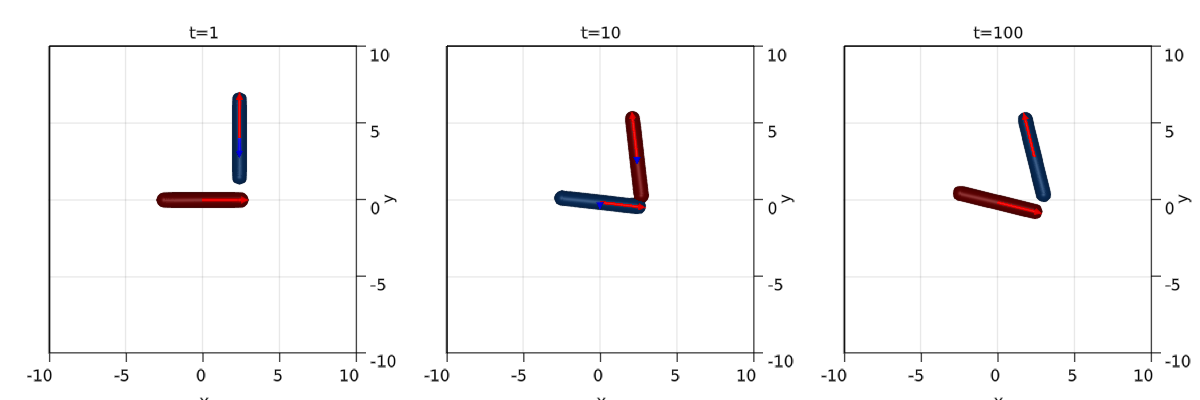

In [70]:
t_list = [1,10,100]

fig = Figure(resolution=(1200,400))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[1].N,2)
    rad = zeros(comt[1].N)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
        rad[i] = comt[t].d[i]/2
    end
    ax = AgentBasedModels.plotRods(fig[1,i],comt[t],dir,:l,rad,color=rand(comt[t].N))
    
    ax.title = string("t=",t_list[i])
    xlims!(ax,com.simulationBox[1,1],com.simulationBox[1,2])
    ylims!(ax,com.simulationBox[2,1],com.simulationBox[2,2])

    #Plot interacting spheres
    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              cos.(comt[t].theta)*comt[t].l[1]/2, sin.(comt[t].theta)*comt[t].l[1]/2, zeros(comt[t].N),
              color=:red,arrowsize=.5,linewidth=.2)
    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              comt[t].vx, comt[t].vy, zeros(comt[t].N),
              color=:blue,arrowsize=.5,linewidth=.2)
end

fig

# Second part of the model: Boundary conditions

In [ ]:
model2 = @agent(2,
    
            [pxUi,pyUi,pxUj,pyUj,pxLi,pyLi,pxLj,pyLj]::Local, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
    
            #Add boundary characteristics
            UpdateVariable=begin
        
                    #Boundary conditions in y
                    xiAux = x; yiAux = y; xjAux=0; yjAux=0; #Declare them in the global scope
                    if y + l/2 + d/2 > simulationBox[2,2] #In the upper boundary region
                        a = -sign(sin(theta))
                        xiAux = x - a*cos(theta)*l/2
                        yiAux = y + abs(sin(theta))*l/2

                        if yiAux >= simulationBox[2,2]#If the bead has surpassed the axis
                            xjAux = xiAux
                            yjAux = yiAux+.0001*d
                        else
                            xjAux = xiAux
                            yjAux = simulationBox[2,2] + d/2
                        end
                    end

                    pxUi = xiAux  #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                    pyUi = yiAux  #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                    pxUj = xjAux  #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                    pyUj = yjAux  #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES   
        
                    #Compute distance between virtual spheres
                    rij = sqrt((xiAux-xjAux)^2 +(yiAux-yjAux)^2)
                    if rij > 0 && rij < d #If it is smaller than a diameter
                        #Compute auxiliar
                        δAux = d - rij
                        MeAux = m/2
                        #Compute interaction
                        nijx = (xiAux-xjAux)/rij
                        nijy = (yiAux-yjAux)/rij
                        vijx = vx
                        vijy = vy
                        #Compute inner product
                        vnAux = nijx*vijx+nijy*vijy
                        #Compute normal and tangential forces
                        FnAux = kn*δAux^1.5-γn*MeAux*δAux*vnAux
                        FtAux = -min(γt*MeAux*δAux^.5,μcc*FnAux)
                        #Compute the interaction forces
                        Fijx = FnAux*nijx + FtAux*(vijx-vnAux*nijx)
                        Fijy = FnAux*nijy + FtAux*(vijy-vnAux*nijy)
                        #Append the interaction forces
                        Fx += Fijx
                        Fy += Fijy
                        #Append radial forces
                        W += ((xiAux-x)*Fijy - (yiAux-y)*Fijx)
                    end

                    xiAux = x; yiAux = y; xjAux=0; yjAux=0; #Declare them in the global scope
                    if y - l/2 - d/2 < simulationBox[2,1] #In the upper boundary region
                        a = sign(sin(theta))
                        xiAux = x - a*cos(theta)*l/2
                        yiAux = y - abs(sin(theta))*l/2
            
                        if yiAux <= simulationBox[2,1]#If the bead has surpassed the axis
                            xjAux = xiAux
                            yjAux = yiAux-.001*d
                        else
                            xjAux = xiAux
                            yjAux = simulationBox[2,1] - d/2
                        end
                    end
        
                    pxLi = xiAux  #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                    pyLi = yiAux  #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                    pxLj = xjAux  #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                    pyLj = yjAux  #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES       
        
                    #Compute distance between virtual spheres
                    rij = sqrt((xiAux-xjAux)^2 +(yiAux-yjAux)^2)
                    if rij > 0 && rij < d #If it is smaller than a diameter
                        #Compute auxiliar
                        δAux = d - rij
                        MeAux = m/2
                        #Compute interaction
                        nijx = (xiAux-xjAux)/rij
                        nijy = (yiAux-yjAux)/rij
                        vijx = vx
                        vijy = vy
                        #Compute inner product
                        vnAux = nijx*vijx+nijy*vijy
                        #Compute normal and tangential forces
                        FnAux = kn*δAux^1.5-γn*MeAux*δAux*vnAux
                        FtAux = -min(γt*MeAux*δAux^.5,μcc*FnAux)
                        #Compute the interaction forces
                        Fijx = FnAux*nijx + FtAux*(vijx-vnAux*nijx)
                        Fijy = FnAux*nijy + FtAux*(vijy-vnAux*nijy)
                        #Append the interaction forces
                        Fx += Fijx
                        Fy += Fijy
                        #Append radial forces
                        W += ((xiAux-x)*Fijy - (yiAux-y)*Fijx)
                    end
        
            end,
    
            UpdateLocal = begin
                if x < simulationBox[1,1] || x > simulationBox[1,2]
                    removeAgent()
                end
            end,
    
            model::BaseModel #Put the other first as I want it to be computed before the motion equations
        )
model2Comp = compile(model2,neighbors="full",platform="cpu");

## Test 1: Interaction with one wall

In [18]:
com = Community(model2Comp,N=8);

for i in keys(constants)
    setindex!(com,constants[i],i)
end

com.m .= 1.
com.d .= 1
com.l .= 5.;

com.x .= [5,5,-5,-5,10,10,-10,-10]
com.y .= [3,-3,3,-3,3,-3,3,-3]
com.vx .= 0
com.vy .= 0
com.ω .= 0
com.theta .= [-π/3,-π/3,π/3,π/3,-2π/3,-2π/3,2π/3,2π/3];

com.simulationBox .= [-20 20;-5 5]
com.radiusInteraction = 6;

In [ ]:
dt = 1
model2Comp = compile(model2,neighbors="full",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");
@time comt = model2Comp.evolve(com,dt=dt,tMax=1000,dtSave=1);

  1.274687 seconds (3.01 M allocations: 177.574 MiB, 6.64% gc time, 96.82% compilation time)


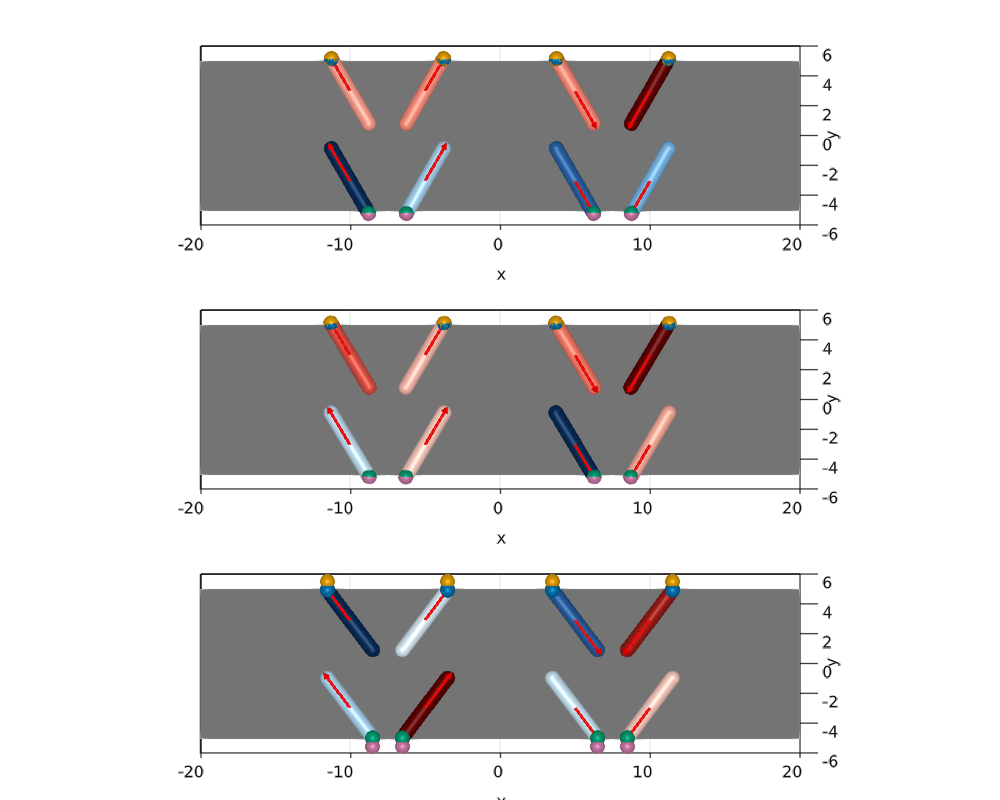

In [74]:
t_list = [2,100,10000]

fig = Figure(resolution=(1000,800))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[t].N,2)
    rad = zeros(comt[t].N)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
        rad[i] = comt[t].d[i]/2
    end
    ax = plotRods(fig[i,1],comt[t],dir,:l,rad,color=rand(comt[t].N))
    m = [[i,j] for i in com.simulationBox[1,:] for j in transpose(com.simulationBox[2,:])]
    m = mapreduce(permutedims, vcat, m)
    faces = [1 2 4;3 4 1]
    mesh!(ax,m,faces,color=:lightgrey)

    xlims!(ax,com.simulationBox[1,1],com.simulationBox[1,2])
    ylims!(ax,com.simulationBox[2,1]-1,com.simulationBox[2,2]+1)
    
    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              cos.(comt[t].theta)*comt[t].l[1]/2, sin.(comt[t].theta)*comt[t].l[1]/2, zeros(comt[t].N),
              color=:red,arrowsize=.5,linewidth=.2)
    
    meshscatter!(ax,comt[t].pxUi[[1,3,5,7]],comt[t].pyUi[[1,3,5,7]],3*ones(4),markersize=.5)
    meshscatter!(ax,comt[t].pxUj[[1,3,5,7]],comt[t].pyUj[[1,3,5,7]],3*ones(4),markersize=.5)

    meshscatter!(ax,comt[t].pxLi[[2,4,6,8]],comt[t].pyLi[[2,4,6,8]],3*ones(4),markersize=.5)
    meshscatter!(ax,comt[t].pxLj[[2,4,6,8]],comt[t].pyLj[[2,4,6,8]],3*ones(4),markersize=.5)

end

fig

## Test 2: Interaction with cells outside walls

In [75]:
com = Community(model2Comp,N=8);

for i in keys(constants)
    setindex!(com,constants[i],i)
end

com.m .= 1.
com.d .= 1
com.l .= 5.;

com.x .= [5,5,-5,-5,20,20,-20,-20]
com.y .= [5,-5,5,-5,5,-5,5,-5]
com.vx .= 0
com.vy .= 0
com.ω .= 0
com.theta .= [-π/3,-π/3,π/3,π/3,-2π/3,-2π/3,2π/3,2π/3];

com.simulationBox .= [-40 40;-4 4]
com.radiusInteraction = 6;

In [82]:
dt = 1
model2Comp = compile(model2,neighbors="full",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");
@time comt = model2Comp.evolve(com,dt=dt,tMax=30000,dtSave=1);

  1.265785 seconds (3.19 M allocations: 196.714 MiB, 6.70% gc time, 85.22% compilation time)


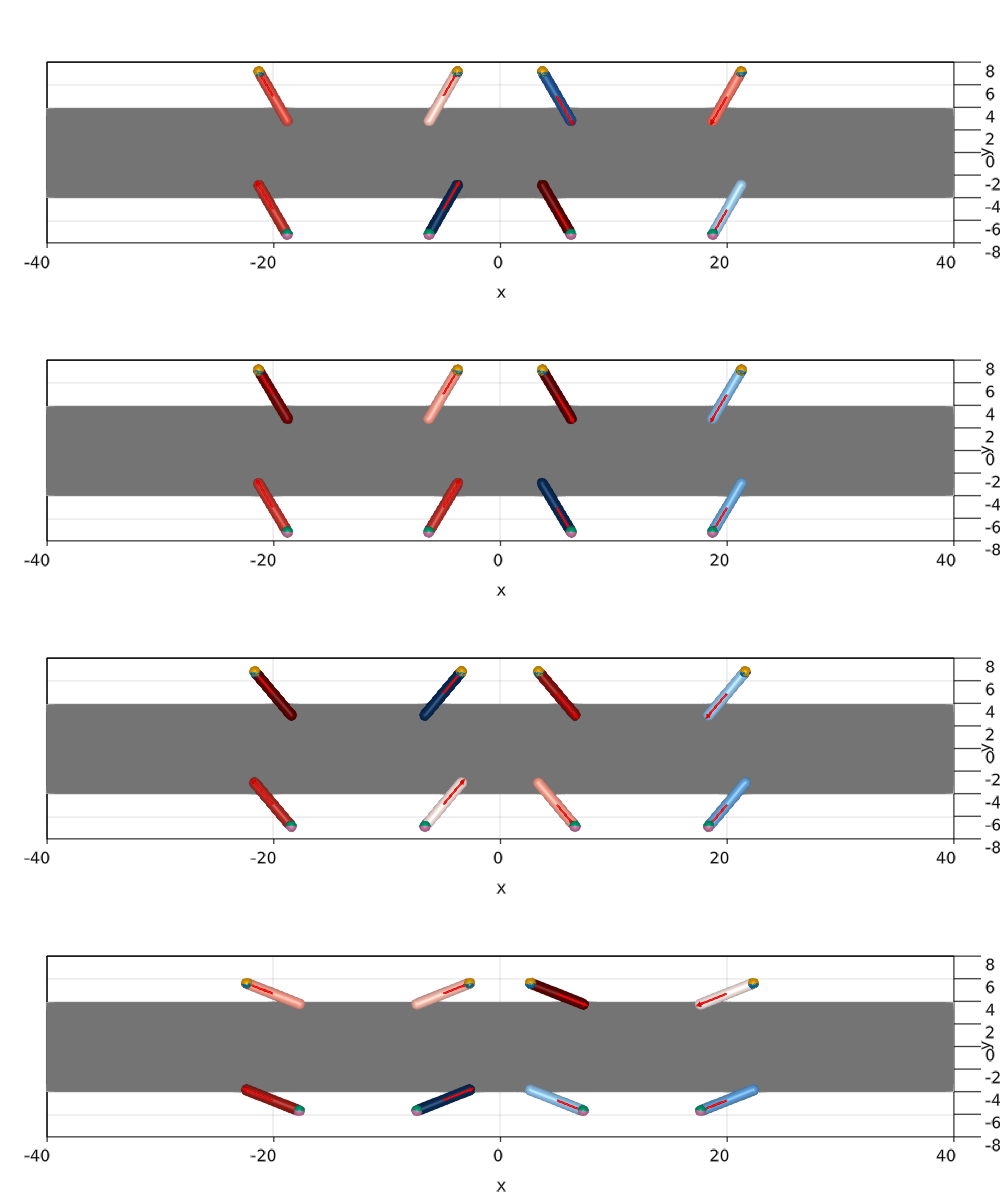

In [83]:
t_list = [2,1000,10000,30000]

fig = Figure(resolution=(1000,1200))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[t].N,2)
    rad = zeros(comt[t].N)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
        rad[i] = comt[t].d[i]/2
    end
    ax = plotRods(fig[i,1],comt[t],dir,:l,rad,color=rand(comt[t].N))
    m = [[i,j] for i in com.simulationBox[1,:] for j in transpose(com.simulationBox[2,:])]
    m = mapreduce(permutedims, vcat, m)
    faces = [1 2 4;3 4 1]
    mesh!(ax,m,faces,color=:lightgrey)

    xlims!(ax,com.simulationBox[1,1],com.simulationBox[1,2])
    ylims!(ax,com.simulationBox[2,1]-4,com.simulationBox[2,2]+4)
    
    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              cos.(comt[t].theta)*comt[t].l[1]/2, sin.(comt[t].theta)*comt[t].l[1]/2, zeros(comt[t].N),
              color=:red,arrowsize=.5,linewidth=.2)
    
    meshscatter!(ax,comt[t].pxUi[[1,3,5,7]],comt[t].pyUi[[1,3,5,7]],3*ones(4),markersize=.5)
    meshscatter!(ax,comt[t].pxUj[[1,3,5,7]],comt[t].pyUj[[1,3,5,7]],3*ones(4),markersize=.5)

    meshscatter!(ax,comt[t].pxLi[[2,4,6,8]],comt[t].pyLi[[2,4,6,8]],3*ones(4),markersize=.5)
    meshscatter!(ax,comt[t].pxLj[[2,4,6,8]],comt[t].pyLj[[2,4,6,8]],3*ones(4),markersize=.5)

end

fig

## Test 3: Interaction with two walls

In [84]:
com = Community(model2Comp,N=4);

for i in keys(constants)
    setindex!(com,constants[i],i)
end

com.m .= 1.
com.d .= 1
com.l .= 5.;

com.x .= [-15,-5,5,15]
com.y .= 0
com.vx .= 0
com.vy .= 0
com.ω .= 0
com.theta .= [-π/3,π/3,-2π/3,2π/3];

com.simulationBox .= [-20 20;-.5 .5]
com.radiusInteraction = 6;

In [85]:
dt = 1
model2Comp = compile(model2,neighbors="full",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");
@time comt = model2Comp.evolve(com,dt=dt,tMax=30000,dtSave=1);

  1.193416 seconds (3.20 M allocations: 192.370 MiB, 91.67% compilation time)


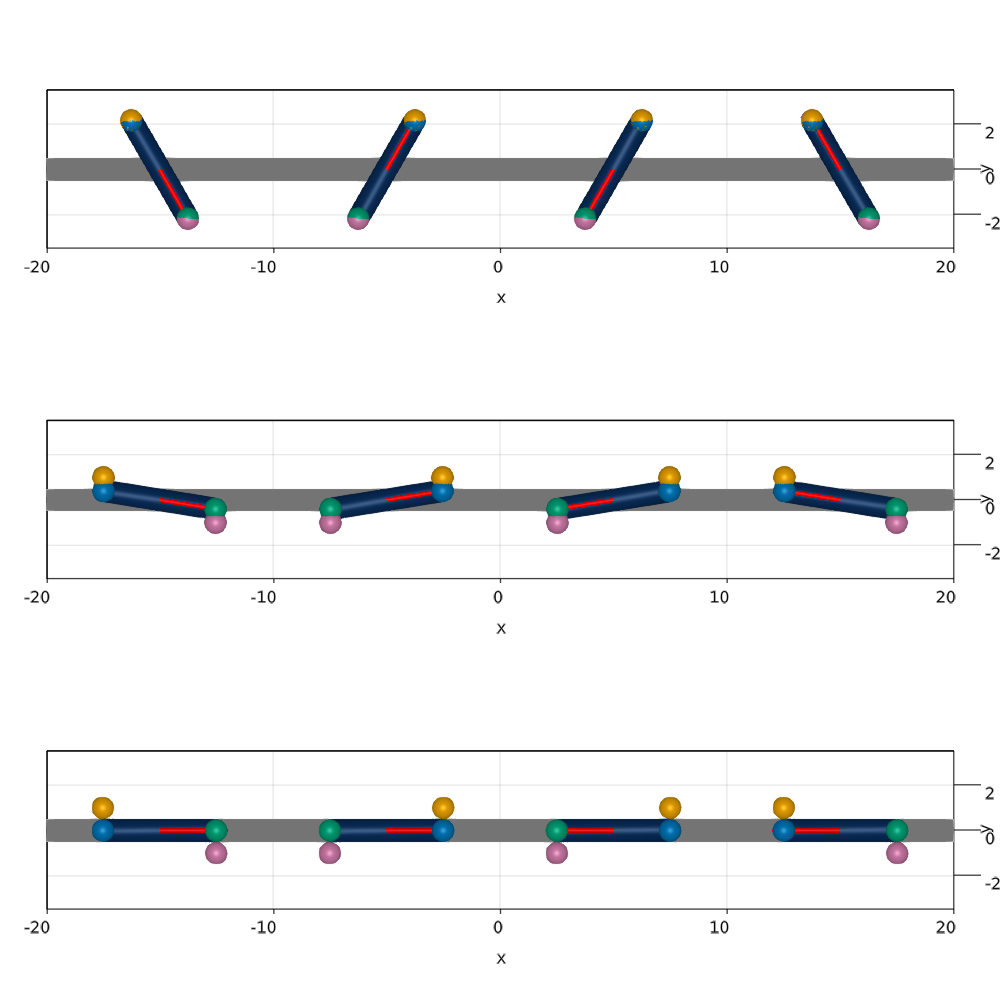

In [86]:
t_list = [2,1000,30000]

fig = Figure(resolution=(1000,1000))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[t].N,2)
    rad = zeros(comt[t].N)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
        rad[i] = comt[t].d[i]/2
    end
    ax = plotRods(fig[i,1],comt[t],dir,:l,rad,color=[0,0,0,0])
    m = [[i,j] for i in com.simulationBox[1,:] for j in transpose(com.simulationBox[2,:])]
    m = mapreduce(permutedims, vcat, m)
    faces = [1 2 4;3 4 1]
    mesh!(ax,m,faces,color=:lightgrey)

    xlims!(ax,com.simulationBox[1,1],com.simulationBox[1,2])
    ylims!(ax,com.simulationBox[2,1]-3,com.simulationBox[2,2]+3)

    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              cos.(comt[t].theta)*comt[t].l[1]/2, sin.(comt[t].theta)*comt[t].l[1]/2, zeros(comt[t].N),
              color=:red,arrowsize=.5,linewidth=.2)
    
    meshscatter!(ax,comt[t].pxUi,comt[t].pyUi,3*ones(4),markersize=.5)
    meshscatter!(ax,comt[t].pxUj,comt[t].pyUj,3*ones(4),markersize=.5)
    meshscatter!(ax,comt[t].pxLi,comt[t].pyLi,3*ones(4),markersize=.5)
    meshscatter!(ax,comt[t].pxLj,comt[t].pyLj,3*ones(4),markersize=.5)
end

fig

## Test 4: Interaction with walls and other cells

In [87]:
com = Community(model2Comp,N=2);

for i in keys(constants)
    setindex!(com,constants[i],i)
end

com.m .= 1.
com.d .= 1
com.l .= 5.;

com.x .= [0,1]
com.y .= 0
com.vx .= 0
com.vy .= 0
com.ω .= 0
com.theta .= [π/3,-2π/3];

com.simulationBox .= [-10 10;-.5 .5]
com.radiusInteraction = 6;

In [91]:
dt = 1
model2Comp = compile(model2,neighbors="full",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");
@time comt = model2Comp.evolve(com,dt=dt,tMax=40000,dtSave=1);

  2.410002 seconds (7.26 M allocations: 519.680 MiB, 2.69% gc time, 50.40% compilation time)


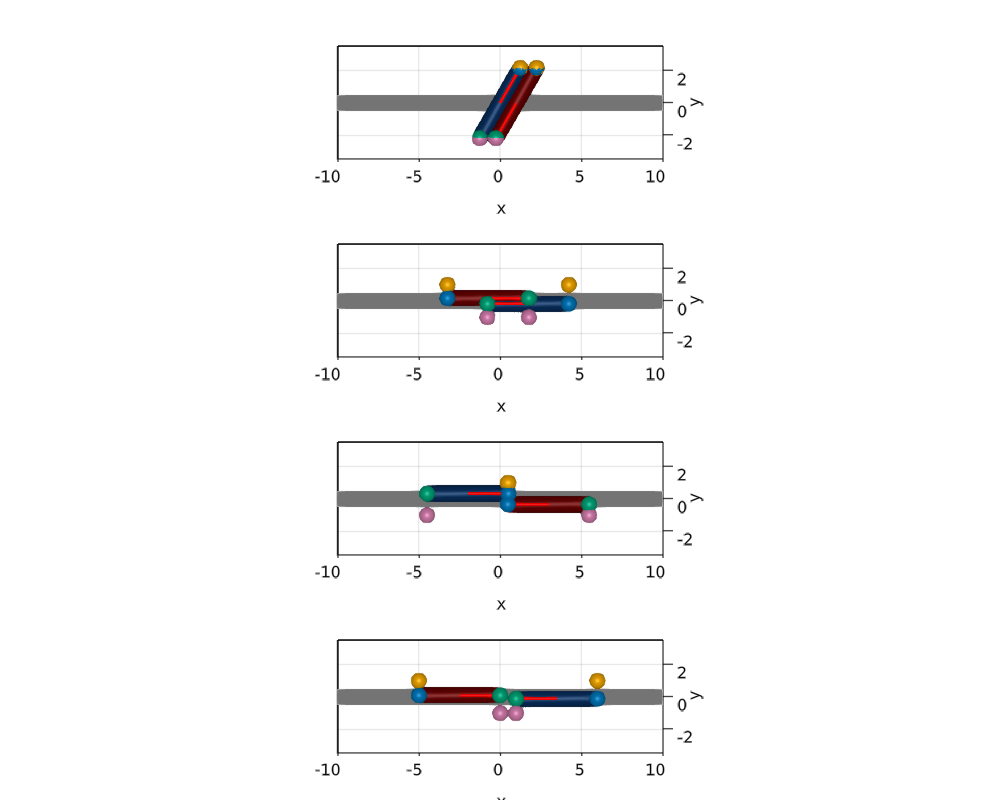

In [95]:
t_list = [2,5000,20000,40000]

fig = Figure(resolution=(1000,800))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[t].N,2)
    rad = zeros(comt[t].N)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
        rad[i] = comt[t].d[i]/2
    end
    ax = plotRods(fig[i,1],comt[t],dir,:l,rad,color=rand(comt[t].N))
    m = [[i,j] for i in com.simulationBox[1,:] for j in transpose(com.simulationBox[2,:])]
    m = mapreduce(permutedims, vcat, m)
    faces = [1 2 4;3 4 1]
    mesh!(ax,m,faces,color=:lightgrey)

    xlims!(ax,com.simulationBox[1,1],com.simulationBox[1,2])
    ylims!(ax,com.simulationBox[2,1]-3,com.simulationBox[2,2]+3)

    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              cos.(comt[t].theta)*comt[t].l[1]/2, sin.(comt[t].theta)*comt[t].l[1]/2, zeros(comt[t].N),
              color=:red,arrowsize=.5,linewidth=.2)
    
    meshscatter!(ax,comt[t].pxUi,comt[t].pyUi,3*ones(2),markersize=.5)
    meshscatter!(ax,comt[t].pxUj,comt[t].pyUj,3*ones(2),markersize=.5)
    meshscatter!(ax,comt[t].pxLi,comt[t].pyLi,3*ones(2),markersize=.5)
    meshscatter!(ax,comt[t].pxLj,comt[t].pyLj,3*ones(2),markersize=.5)

end

fig

## Test 5: Interaction in chamber tight chamber between two cells

In [97]:
com = Community(model2Comp,N=2);

for i in keys(constants)
    setindex!(com,constants[i],i)
end

com.m .= 1.
com.d .= 1
com.l .= [5.,2.5];

com.x .= [0,1]
com.y .= [-.25,.25]
com.vx .= 0
com.vy .= 0
com.ω .= 0
com.theta .= [0,π];

com.simulationBox .= [-20 20;-.6 .6]
com.radiusInteraction = 6;

In [103]:
dt = 1
model2Comp = compile(model2,neighbors="full",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");
@time comt = model2Comp.evolve(com,dt=dt,tMax=50000,dtSave=1);

  2.663139 seconds (8.29 M allocations: 606.027 MiB, 3.65% gc time, 39.79% compilation time)


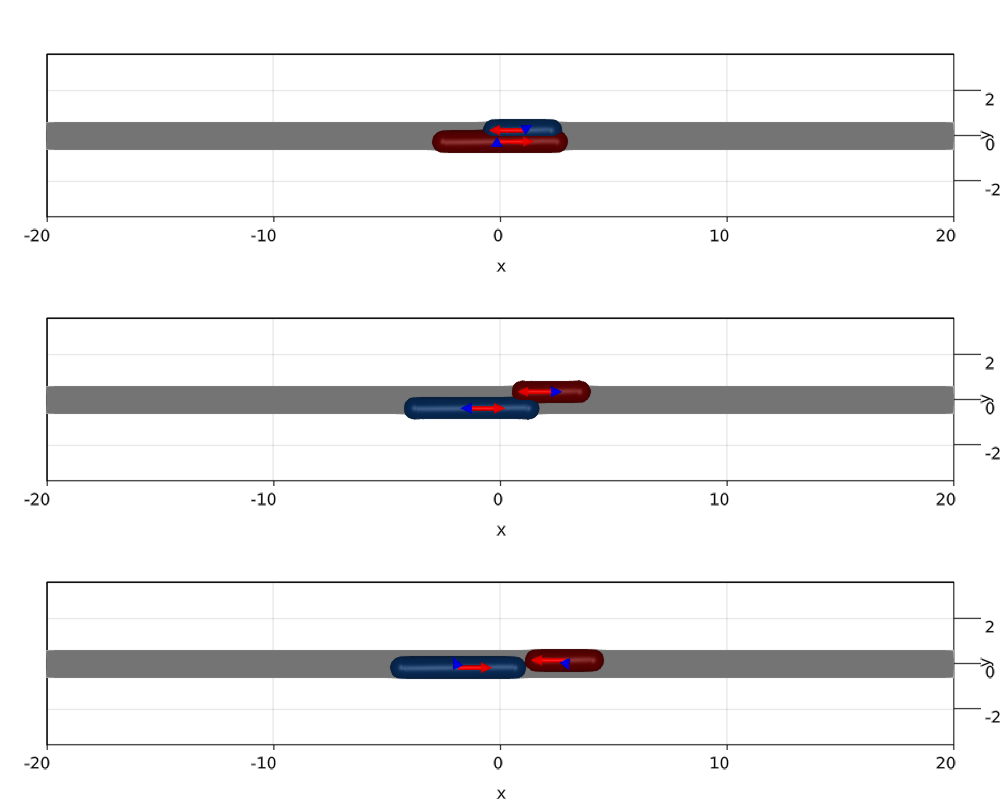

In [104]:
t_list = [2,20000,50000]

fig = Figure(resolution=(1000,800))

for (i,t) in enumerate(t_list)
    dir = zeros(comt[t].N,2)
    rad = zeros(comt[t].N)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
        rad[i] = comt[t].d[i]/2
    end
    ax = plotRods(fig[i,1],comt[t],dir,:l,rad,color=rand(comt[t].N))
    m = [[i,j] for i in com.simulationBox[1,:] for j in transpose(com.simulationBox[2,:])]
    m = mapreduce(permutedims, vcat, m)
    faces = [1 2 4;3 4 1]
    mesh!(ax,m,faces,color=:lightgrey)

    xlims!(ax,com.simulationBox[1,1],com.simulationBox[1,2])
    ylims!(ax,com.simulationBox[2,1]-3,com.simulationBox[2,2]+3)

    #arrows!(ax,
    #          comt[t].x,comt[t].y,3 .*ones(comt[t].N),
    #          cos.(comt[t].theta)*comt[t].l[1]/2, sin.(comt[t].theta)*comt[t].l[1]/2, zeros(comt[t].N),
    #          color=:red,arrowsize=.5,linewidth=.2)
    
    #meshscatter!(ax,comt[t].pxUi,comt[t].pyUi,3*ones(2),markersize=.5)
    #meshscatter!(ax,comt[t].pxUj,comt[t].pyUj,3*ones(2),markersize=.5)
    #meshscatter!(ax,comt[t].pxLi,comt[t].pyLi,3*ones(2),markersize=.5)
    #meshscatter!(ax,comt[t].pxLj,comt[t].pyLj,3*ones(2),markersize=.5)

    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              cos.(comt[t].theta), sin.(comt[t].theta), zeros(comt[t].N),
              color=:red,arrowsize=.5,linewidth=.2)
    
    arrows!(ax,
              comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              comt[t].Fx, comt[t].Fy, zeros(comt[t].N),
              color=:blue,arrowsize=.5,linewidth=.2)
    
end

fig

# Third part of the model: Growth

In [ ]:
model3 = @agent(2,
            model2::BaseModel,
    
            lTarget::Local,
            [growth,lMax,σLTarget,σTorqueDivision]::Global, #Growth parameters

            UpdateVariable = begin
                    d(l) = growth*dt
            end,

            UpdateLocal = begin #Bound cells

                #Add division
                if l > lTarget
                    torque = σLTarget*Uniform(-σTorqueDivision,σTorqueDivision)
                    addAgent(
                            x=(l+d)/4*cos(theta)+x,
                            y=(l+d)/4*sin(theta)+y,
                            l=l/2-d/2,
                            vx = vx,
                            vy = vy,
                            theta = theta,
                            ω = torque,
                            d = d,
                            m = m/2,
                            lTarget = lMax+σLTarget*Uniform(-1,1),
                            pxAuxi = pxAuxi, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pxAuxj = pxAuxj, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pyAuxi = pyAuxi, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pyAuxj = pyAuxj, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pxUi = pxUi, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pxUj = pxUj, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pyUi = pyUi, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pyUj = pyUj, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pxLi = pxLi, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pxLj = pxLj, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pyLi = pyLi, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pyLj = pyLj, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            )
                    addAgent(
                            x=-(l+d)/4*cos(theta)+x,
                            y=-(l+d)/4*sin(theta)+y,
                            l=l/2-d/2,
                            vx = vx,
                            vy = vy,
                            theta = theta,
                            ω = torque,
                            d = d,
                            m = m/2,
                            lTarget = lMax+σLTarget*Uniform(-1,1),
                            pxAuxi = pxAuxi, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pxAuxj = pxAuxj, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pyAuxi = pyAuxi, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pyAuxj = pyAuxj, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pxUi = pxUi, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pxUj = pxUj, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pyUi = pyUi, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pyUj = pyUj, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pxLi = pxLi, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pxLj = pxLj, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pyLi = pyLi, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            pyLj = pyLj, #AUXILIAR CODE TO VISUALIZE VIRTUAL SPHERES
                            )
                    removeAgent()
                end
                
                #m = l
            end
    );

model3Comp = compile(model3,integrator="ImplicitEuler",neighbors="grid",platform="cpu");
#model3Comp.program
#model3.declaredSymbols["Local"]

## Test 1: Interactions growing

In [26]:
com = Community(model3Comp,N=14);

for i in keys(constants)
    setindex!(com,constants[i],i)
end
for i in keys(constantsGrowth)
    setindex!(com,constantsGrowth[i],i)
end

com.m .= 1.
com.d .= 1.
com.l .= 4.8;
com.lTarget .= 6.;

com.x .= [-15,-19,-1,3,13,15,-15,-14,-0,-1,14,15,-15,-20.8]
com.y .= [0,1,0,4,0,1,-10,-9,-10,-9,-10,-10,-20,-20]
com.theta .= [0,π/2,0,π/2,0,π/2,0,0.1,0,-0.1,0,0,0,0]

com.simulationBox .= [-25 20;-25 5]

com.radiusInteraction = 6;

In [27]:
dt = 1
model3Comp = compile(model3,neighbors="grid",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");
@time comt = model3Comp.evolve(com,dt=dt,tMax=4000,dtSave=1,nMax=1000);

  1.420633 seconds (2.77 M allocations: 190.304 MiB, 6.36% gc time, 78.55% compilation time)


In [28]:
t_list = [2,10000,20000]

fig = Figure(resolution=(2000,2000))

#ax = Axis(fig[1,1:length(t_list)])
#lines!(ax,comt.t,comt.N)

Fx = copy(comt.Fx)
Fx[isnan.(Fx)] .= 0
Fx = sum(abs.(Fx),dims=2)./comt.N
Fy = copy(comt.Fy)
Fy[isnan.(Fy)] .= 0
Fy = sum(abs.(Fy),dims=2)./comt.N
W = copy(comt.W)
W[isnan.(W)] .= 0
W = sum(abs.(W),dims=2)./comt.N

ax = Axis(fig[1,1])
l1 = lines!(ax,comt.t,Fx[:,1])
l2 = lines!(ax,comt.t,Fy[:,1])
l3 = lines!(ax,comt.t,W[:,1])
for i in t_list
    x = comt.t[i] .* ones(length(comt.t))
    y = range(0,.4,length=length(comt.t))
    lines!(ax,x,y,color="black")
end

ax = Axis(fig[2,1])
lines!(ax,comt.t,comt.N)

for (i,t) in enumerate(t_list)
    dir = zeros(comt[t].N,2)
    rad = zeros(comt[t].N)
    for i in 1:comt[t].N
        dir[i,1] = cos(comt[t].theta[i])
        dir[i,2] = sin(comt[t].theta[i])
        rad[i] = comt[t].d[i]/2
    end
    ax = plotRods(fig[3,i],comt[t],dir,:l,rad,color=[abs(i) for i in comt[t].vx])

    xlims!(ax,com.simulationBox[1,1],com.simulationBox[1,2])
    ylims!(ax,com.simulationBox[2,1],com.simulationBox[2,2])
    
    for p in 1:2:com.N
        meshscatter!(ax,[comt[t].pxAuxi[p],comt[t].pxAuxj[p]],[comt[t].pyAuxi[p],comt[t].pyAuxj[p]],[2,2],markersize=.5,color=:red)
    end
    for p in 2:2:com.N
        meshscatter!(ax,[comt[t].pxAuxi[p],comt[t].pxAuxj[p]],[comt[t].pyAuxi[p],comt[t].pyAuxj[p]],[4,4],markersize=.2,color=:green)
    end
    
    arrows!(ax,
            comt[t].x,comt[t].y,3 .*ones(comt[t].N),
              comt[t].Fx, comt[t].Fy, zeros(comt[t].N),
              color=:red,arrowsize=.5,linewidth=.2)
end

fig

LoadError: BoundsError: attempt to access 4001-element Vector{Float64} at index [10000]

## Test 2: Growth in a one cell thick chamber

In this experiment we can see that the initial cells aligns to the chamber while growing. As it grows it starts dividing and the grownth along the chamber is correct up to some time points where the simulations break. This is due to the unstability coming from the growth and the number of cells. 

Since the growth is linear for every cell. The total growth in the chamber $L$ is related to the individual growth:

$$ dL/dt = \sum_i dl_i/dt = N*growth$$

It reaches a point that is the chamber is long enough, the relaxations of the forces is smaller than the growth rate and the simulation becomes unstable. The parameters have to be properly tunned to take into account this issue.

In [6]:
com = Community(model3Comp,N=1);

for i in keys(constants)
    setindex!(com,constants[i],i)
end
for i in keys(constantsGrowth)
    setindex!(com,constantsGrowth[i],i)
end

com.m .= 1.
com.d .= 1.
com.l .= 2.;
com.lTarget .= 3.;

com.x .= 0
com.y .= 0
com.theta .= rand(Uniform(-1,1),com.N)

com.simulationBox .= [-40 40;-.5 .5]
com.radiusInteraction = 6;

In [7]:
dt = 1
model3Comp = compile(model3,neighbors="grid",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");
@time comt = model3Comp.evolve(com,dt=dt,tMax=120000,dtSave=1000,nMax=1000);

 11.583393 seconds (22.24 M allocations: 1.629 GiB, 1.95% gc time, 33.06% compilation time)


In [8]:
fig = Figure(resolution=(1000,1000))
videoRods(fig,comt,save="videoSingleCellChannel.mp4",color=(x)->abs.(cos.(x.theta[:,1])),colorrange=[0,1],sampling=2:100:length(comt))

"videoSingleCellChannel.mp4"

## Test 3: Growth of a community

In [10]:
com = Community(model3Comp,N=1);

for i in keys(constants)
    setindex!(com,constants[i],i)
end
for i in keys(constantsGrowth)
    setindex!(com,constantsGrowth[i],i)
end

com.m .= 1.
com.d .= 1.
com.l .= 2.9;
com.lTarget .= 3.;

com.x .= [0]
com.y .= [0]
com.theta .= [0]

com.simulationBox .= [-30 30;-30 30]

com.radiusInteraction = 6;

In [11]:
dt = 1
model3Comp = compile(model3,neighbors="grid",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");
@time comt = model3Comp.evolve(com,dt=dt,tMax=150000,dtSave=1,nMax=1000);

 39.452643 seconds (22.19 M allocations: 4.500 GiB, 4.01% gc time, 3.83% compilation time)


In [12]:
fig = Figure(resolution=(1000,1000))
videoRods(fig,comt,save="videoComunity.mp4",color=(x)->abs.(cos.(x.theta[:,1])),colorrange=[0,1],sampling=2:100:length(comt))

"videoComunity.mp4"

## Test 3: Growth in a small channel

In [13]:
com = Community(model3Comp,N=1);

for i in keys(constants)
    setindex!(com,constants[i],i)
end
for i in keys(constantsGrowth)
    setindex!(com,constantsGrowth[i],i)
end

com.m .= 1.
com.d .= 1.
com.l .= 3.;
com.lTarget .= 3.1;

com.x .= 0
com.y .= 0
com.theta .= rand(Uniform(-40,40),com.N)

com.simulationBox .= [-20 20;-2.5 2.5]
com.radiusInteraction = 6;

In [14]:
dt = 1
model3Comp = compile(model3,neighbors="grid",integrator="VerletVelocity",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");
@time comt = model3Comp.evolve(com,dt=dt,tMax=200000,dtSave=10,nMax=4500);

 42.719494 seconds (22.83 M allocations: 2.092 GiB, 0.46% gc time, 2.70% compilation time)


In [ ]:
fig = Figure(resolution=(1000,1000))
videoRods(fig,comt,save="videoSmallChannel.mp4",color=(x)->abs.(cos.(x.theta[:,1])),colorrange=[0,1],sampling=2:10:length(comt))

## Test 4: Growth in a big channel

In [ ]:
com = Community(model3Comp,N=1);

for i in keys(constants)
    setindex!(com,constants[i],i)
end
for i in keys(constantsGrowth)
    setindex!(com,constantsGrowth[i],i)
end

com.m .= 1.
com.d .= 1.
com.l .= 3.;
com.lTarget .= 3.1;

com.x .= 0
com.y .= 0
com.theta .= rand(Uniform(-40,40),com.N)

com.simulationBox .= [-20 20;-10 10]
com.radiusInteraction = 6;

In [ ]:
dt = 1
model3Comp = compile(model3,neighbors="grid",integrator="Heun",velocities=Dict([:x=>:vx,:y=>:vy,:theta=>:ω]),platform="cpu");
@time comt = model3Comp.evolve(com,dt=dt,tMax=200000,dtSave=1000,nMax=10000);

In [ ]:
fig = Figure(resolution=(1000,1000))
videoRods(fig,comt,save="videoBigChannel.mp4",color=(x)->abs.(cos.(x.theta[:,1])),colorrange=[0,1],sampling=2:10:length(comt))